# Imports

In [68]:
import os
import sys
import copy
import glob
import tqdm
from torch import nn
import random
import torch
import platform
from typing import Callable, List, Optional, Dict
import numpy as np
import scipy.sparse as sp

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModel

import torch_geometric
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    Batch
    )
import torch_geometric.datasets as datasets
import torch_geometric.transforms as transforms
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, silhouette_score

# To ensure determinism
seed = 1234
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed)

# Check versions
print(torch.__version__)
print(torch.version.cuda)
print(platform.python_version())
print(torch_geometric.__version__)

1.8.1+cu101
10.1
3.8.18
1.7.0


# Process To Graph Data

In [69]:
folders = ["/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Code_kernel_data/after_pruning/NEW/Timestamp.compareTo"]

In [70]:
def get_nodes_edges(inTextFile, add_reverse_edges = False):
  # FD = 0, CD = 1
  # to support the hetero data object as suggested by the documentation 
  nodes_dict = {}
  edge_indices_CD = []
  edge_indices_FD = []

  #to support the Data object as used by the Entities dat object as used in RGAT source code
  edge_indices = []
  edge_type = []
  
  # nodes_dict is an index_map
  node_count=0
  with open(inTextFile) as fp:
    
    file_name = inTextFile.split("/")[-1].strip()

    Lines = fp.readlines()
    for line in Lines:

      N = line.split('-->')
      N[0], N[1] = N[0].strip(), N[1].strip()
      
      #t1 = N[0].split('$$')   
      src = N[0].strip()   
      if src not in nodes_dict.keys():
        nodes_dict[src] = node_count
        node_count+=1
        
      #t2 = N[1].split('$$')
      right_idx = N[1].rfind('[')
      dst = N[1][:right_idx].strip()
      if dst not in nodes_dict.keys():
        nodes_dict[dst] = node_count
        node_count+=1

      x = N[1].strip()[right_idx + 1 : -1].strip()
      if(x == 'FD'):
        y=0
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_FD.append([nodes_dict[src], nodes_dict[dst]])
      else: 
        y=1
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_CD.append([nodes_dict[src], nodes_dict[dst]])
     
  return nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name

In [71]:
file = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Code_kernel_data/before_pruning/NEW/Timestamp.compareTo/16_sample-0_Timestamp.compareTo_graph_dump.txt"

get_nodes_edges(file, add_reverse_edges = False)

({'Line_0 $$ Entry': 0,
  'Line_1 $$ public class func': 1,
  'Line_2 $$ public void checkFeatureTimestamp(final String schema, final String uniquename, final GmodDAO dao, final String keyName, final Hashtable<String, Feature> featureIdStore, final ChadoTransaction tsn)': 2,
  'Line_3 $$ timestamp.setNanos(0)': 3,
  'Line_4 $$ if (now.compareTo(timestamp) != 0)': 4,
  'Line_6 $$ final SimpleDateFormat date_format = new SimpleDateFormat("dd.MM.yyyy hh:mm:ss z")': 5,
  'Line_8 $$ int select = JOptionPane.showConfirmDialog(null, uniquename + " has been altered at :\\n" + date_format.format(now) + "\\nOverwite?", "Feature Changed", JOptionPane.OK_CANCEL_OPTION)': 6,
  'Line_13 $$ if (select == JOptionPane.OK_OPTION)': 7,
  'Line_14 $$ return true': 8,
  'Line_16 $$ return false': 9},
 [[5, 6], [6, 7]],
 [[0, 1],
  [1, 2],
  [2, 3],
  [2, 4],
  [4, 5],
  [4, 6],
  [6, 6],
  [4, 7],
  [7, 8],
  [7, 9]],
 [[0, 1],
  [1, 2],
  [2, 3],
  [2, 4],
  [4, 5],
  [4, 6],
  [6, 6],
  [5, 6],
  [4, 7],

In [72]:
#Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Initialize the models
codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")
codebert_model = codebert_model.to(device)

def get_node_embedding_from_codebert(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_line = code_line.split("$$")[1].strip()
        code_tokens = codebert_tokenizer.tokenize(code_line, truncation=True, max_length=510)
        tokens = [codebert_tokenizer.cls_token]+code_tokens+[codebert_tokenizer.eos_token]
        tokens_ids = torch.tensor(codebert_tokenizer.convert_tokens_to_ids(tokens))
        tokens_ids = tokens_ids.to(device)
        context_embeddings = codebert_model(tokens_ids[None,:])
        cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
        list_of_embeddings.append(cls_token_embedding)
    return torch.stack(list_of_embeddings)

In [73]:
def create_graph_dataset(folders):
  dataset =[]
  for label, folder in tqdm.tqdm(enumerate(folders)):
    print("\nProcessing: {}\n".format(folder))
    files = glob.glob(os.path.join(folder, '*.txt'))
    print("\nNumber of files: {}\n".format(len(files)))
    count = 0
    for file in files:

      if(count % 5 == 0):
          print("\nAt file: {}\n".format(count))
                        
      try:
          nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name = get_nodes_edges(file, add_reverse_edges = True)
      except Exception as e:
          print("\nError: ", e)
          continue
                    
      if(len(nodes_dict) == 0):
          print("\nNo Data: ", file)
          continue
      #print(nodes_dict, edge_indices_CD, edge_indices_FD, edge_type)

      # Node feature matrix with shape [num_nodes, num_node_features]=(N, 768).
      try:
          CodeEmbedding = get_node_embedding_from_codebert(nodes_dict)
      except Exception as e :
          print("\nError: ", e)
          print(nodes_dict)
          continue
      #print(CodeEmbedding.shape)

      # FIXING DATA FOTMATS AND SHAPE
      x = torch.tensor(CodeEmbedding)
      # print(x.shape)
  
      # data.y: Target to train against (may have arbitrary shape),
      # graph-level targets of shape [1, *]
      label = 1
      y = torch.tensor([label], dtype=torch.long)
      #print(type(y))

      # edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]
      edge_index_CD = torch.tensor(edge_indices_CD, dtype=torch.long).t().contiguous()
      edge_index_FD = torch.tensor(edge_indices_FD, dtype=torch.long).t().contiguous()
      edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
      edge_attr = torch.tensor(edge_type, dtype=torch.long).t().contiguous()
      #print(edge_index_CD, edge_index_FD, edge_index, edge_type)
  
      data = Data(edge_index=edge_index, edge_attr=edge_attr, x=x)
      data.id = torch.tensor([count])
      data.y = y
      # data.num_nodes = len(nodes_dict)
      data.api = file_name
      dataset.append(data)
      count += 1
    
  return dataset

dataset = create_graph_dataset(folders)
print("\nLength of the dataset: ", len(dataset))

0it [00:00, ?it/s]


Processing: /home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Code_kernel_data/after_pruning/NEW/Timestamp.compareTo


Number of files: 22


At file: 0


At file: 5


At file: 10


At file: 15



1it [00:01,  1.66s/it]


At file: 20


Length of the dataset:  22


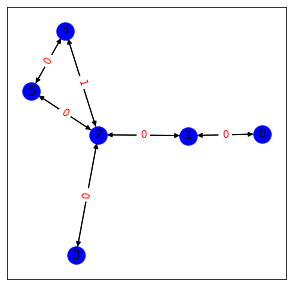

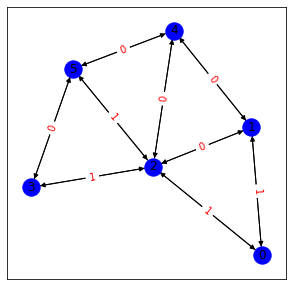

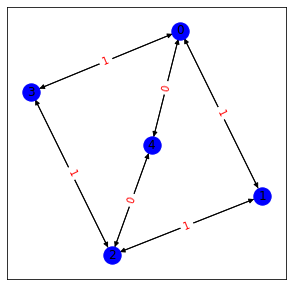

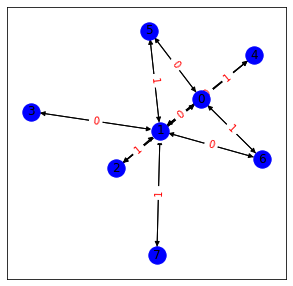

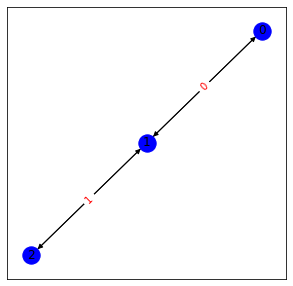

In [74]:
def visualize_graph(data, color):
    G = to_networkx(data, to_undirected=False)
    edge_labels = {}
    for i in range(len(G.edges)):
        edge = list(G.edges)[i]
        edge_labels[edge[0], edge[1]] = int(data.edge_attr[i])
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_color='red')
    plt.show()

for G in dataset[:5]:
    visualize_graph(G, color="blue")

# Build/Load The Model

In [75]:
from model import GNN, GNN_graphpred

#set up model
num_layer = 3
emb_dim = 768
gnn_type = "gcn"
num_tasks = 1
JK = "last"
dropout_ratio = 0.5
graph_pooling = "mean"
input_model_file = "/home/siddharthsa/cs21mtech12001-Tamal/API-Misuse-Prediction/PDG-gen/Repository/Graph-Models/MuGNN/output/saved_models/gcn_1_3_5_e100_model_ck_code2seq.pth"

gnn_graphpred_model = GNN_graphpred(num_layer, emb_dim, num_tasks, JK = JK, drop_ratio = dropout_ratio, graph_pooling = graph_pooling, gnn_type = gnn_type)
gnn_graphpred_model.from_pretrained(input_model_file)

gnn_model = GNN(num_layer, emb_dim, JK, drop_ratio = dropout_ratio, gnn_type = gnn_type)
gnn_model.load_state_dict(torch.load(input_model_file))

print("Loaded the model!!")

Loaded the model!!


# Get The Embeddings

In [76]:
embeddings = []
for i in range(len(dataset)):
    node_representation = gnn_model(dataset[i].x, dataset[i].edge_index, dataset[i].edge_attr)
    graph_representation = global_mean_pool(x = node_representation, batch = torch.tensor([0]*(len(node_representation))))[0]
    dataset[i].embedding = graph_representation.detach().numpy()
    embeddings.append(graph_representation.detach().numpy())

# Visualize using UMAP

In [77]:
from umap import UMAP
import plotly.express as px
import pandas as pd

def visualize_clusters_using_umap(vectors, clusters):

    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    umap_output_2d = umap_2d.fit_transform(vectors)
    umap_dataframe_2d = pd.DataFrame(umap_output_2d)
    umap_dataframe_2d['cluster'] = clusters
    umap_dataframe_2d.columns = ['x1','x2', 'cluster']

    umap_3d = UMAP(n_components=3, init='random', random_state=0)
    umap_output_3d = umap_3d.fit_transform(vectors)
    umap_dataframe_3d = pd.DataFrame(umap_output_3d)
    umap_dataframe_3d['cluster'] = clusters
    umap_dataframe_3d.columns = ['x1','x2', 'x3', 'cluster']

    fig_2d = px.scatter(
        umap_dataframe_2d[["x1", "x2"]], x="x1", y="x2",
        color=umap_dataframe_2d["cluster"], labels={'color': 'clusters'}
    )
    fig_3d = px.scatter_3d(
        umap_dataframe_3d[["x1", "x2", "x3"]], x="x1", y="x2", z="x3",
        color=umap_dataframe_3d["cluster"], labels={'color': 'clusters'}
    )
    fig_3d.update_traces(marker_size=5)

    fig_2d.show()
    fig_3d.show()

# Cluster The Embeddings

## Birch Clustering

In [78]:
from sklearn.cluster import Birch

birch_model = Birch(n_clusters = None)
clusters_birch = birch_model.fit_predict(embeddings)
clusters_birch = birch_model.predict(embeddings)

In [79]:
visualize_clusters_using_umap(embeddings, clusters_birch)

## DBSCAN Clustering

In [80]:
from sklearn.cluster import DBSCAN

clusters_dbscan = DBSCAN(eps=10, min_samples=4).fit_predict(embeddings)

In [81]:
visualize_clusters_using_umap(embeddings, clusters_dbscan)

## K-Means Clustering

#### Get optimal clusters number

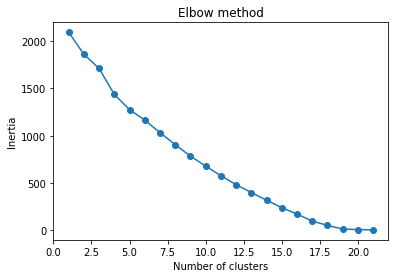

In [82]:
def elbow_for_kmeans(embeddings):

    inertias, no_of_clusters = [], list(range(1, len(embeddings)))

    for i in no_of_clusters:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)

    plt.plot(no_of_clusters, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()
    
elbow_for_kmeans(embeddings)

#### Do clustering

In [83]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(embeddings)
clusters_kmeans = kmeans.predict(embeddings)
print(clusters_kmeans)

[9 2 0 2 4 2 3 2 7 2 2 2 2 2 1 2 2 2 2 6 5 8]


In [84]:
visualize_clusters_using_umap(embeddings, clusters_kmeans)